## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "orchestrator-Synthesizer"

# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
# llm = ChatGroq(model="qwen-2.5-coder-32b", temperature=0.7)

## Define the Initial State

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END

from langgraph.checkpoint.memory import MemorySaver
# from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display


In [3]:
from typing import Annotated, List
from pydantic import BaseModel, Field
import operator

# Schema for structured output to use in planning
class Article(BaseModel):
    name: str = Field(
        description="Name of the current article",
    )
    description: str = Field(
        description="Relevant information extracted from the current article.",
    )


class Articles(BaseModel):
    articles: List[Article] = Field(
        description="""URL's of the different articles that contains the information to produce a final 
        report with the information collected.""",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Articles)

In [4]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    urls: str # urls to search for information
    articles: list[Article]  # List of Articles
    completed_articles: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    article: Article
    completed_articles: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that will split the URL's among workers to get relevant information to the topic 
    in a parallel way."""

    # Generate queries
    articles_urls = planner.invoke(
        [
            SystemMessage(content=f"""Assign the {state['urls']} containing the information in an article or articles
                          to different workers. Each worker will collect the relevant information to the 
                          {state['topic']} in an independent way. They will pass the relevant information 
                          to the synthetizer."""),
        ]
    )

    print("Report Articles:",articles_urls)

    return {"articles": articles_urls.articles}

def llm_call(state: WorkerState):
    """Worker collects the relevant information to the topic contained in the assigned URL."""

    # Generate section
    article = llm.invoke(
        [
            SystemMessage(
                content="""From the assigned URL, collect the relevant information to the topic given by the user"""
            ),
            HumanMessage(
                content=f"Here is the section name: {state['article'].name} and description: {state['article'].description}"
            ),
        ]
    )
    
    return {"completed_articles": [article.content]}


def synthesizer(state: State):
    """Synthesize full report from articles collected data."""

    # List of completed sections
    completed_articles = state["completed_articles"]
    completed_report_articles = "\n\n---\n\n".join(completed_articles)

    # Format completed section to str to use as context for final sections
    completed_report_articles = llm.invoke(
        [
            SystemMessage(
                content=f"""From the information collected in {completed_report_articles}, produce a coherent,
                complete, and concise report including all the relevant information, as a summary of all the
                information contained in the URL's relevant to the topic."""
            ),            
        ]
    )
    
    return {"final_report": completed_report_articles}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each URL """

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"article": s}) for s in state["articles"]]


## Defining the Graph

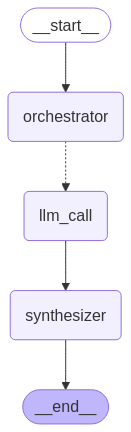

In [5]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
# state = orchestrator_worker.invoke({"topic": "Create a report on NVIDIA stock"})

# from IPython.display import Markdown
# Markdown(state["final_report"])

## Using the Agent

In [7]:
# Input
# topic = input("Provide the topic for the report")
topic = "Nvidia stock"
# URLs=input("Provide the URL's where you want to extract the information of")
URLs ="""https://finance.yahoo.com/video/short-sellers-already-profited-over-214233284.html
https://finance.yahoo.com/m/4e924318-7952-351b-8ee5-336d98883fe6/nvidia-ceo-jensen-huang.html
https://finance.yahoo.com/news/why-ionq-stock-got-thrashed-215900363.html
https://www.thestreet.com/technology/analysts-turn-heads-with-nvidia-stock-price-target-move
"""
# Invoke
state = orchestrator_worker.invoke({"topic": f"{topic}","urls":f"{URLs}"})

Report Articles: articles=[Article(name='Short Sellers Already Profited Over Nvidia', description="The article discusses how short sellers have already made significant profits from Nvidia's stock decline, highlighting the volatility and market reactions surrounding the company's performance."), Article(name="Nvidia CEO Jensen Huang's Insights", description="This article features insights from Nvidia CEO Jensen Huang regarding the company's future prospects and strategies, which may impact stock performance and investor sentiment."), Article(name='Why IonQ Stock Got Thrashed', description="While primarily focused on IonQ, the article provides context on the tech sector's performance, including Nvidia, and discusses market trends that could affect Nvidia's stock."), Article(name='Analysts Turn Heads with Nvidia Stock Price Target Move', description="This article reports on analysts adjusting their price targets for Nvidia stock, reflecting changing market conditions and expectations for

In [8]:

from IPython.display import Markdown
Markdown(state["final_report"].content)


The recent analysis of Nvidia's stock performance reveals significant volatility, which has created opportunities for short sellers to profit from the company's stock decline. As Nvidia has faced various challenges, including market reactions to its performance, short sellers have strategically capitalized on the fluctuations in share price. This highlights the inherent risks and rewards associated with short selling, particularly in a high-profile stock like Nvidia, known for its notable ups and downs in valuation.

In addition to the short selling dynamics, analysts have been revising their price targets for Nvidia's stock, reflecting a shift in sentiment regarding the company's growth prospects. These adjustments are influenced by several factors, including technological advancements, competitive pressures, and broader market trends. The changes in price targets may impact investor decisions and indicate analysts' confidence in Nvidia's future trajectory.

Overall, the interplay between short selling, analyst sentiment, and market conditions underscores the complexities of investing in Nvidia and similar tech stocks, where rapid changes can lead to both significant risks and potential rewards.